In [1]:
from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionGeometry, AcquisitionData
from ccpi.optimisation.algorithms import CGLS, FISTA
from ccpi.optimisation.functions import Norm2Sq, L1Norm
from ccpi.optimisation.operators import BlockOperator, Gradient, Identity
from ccpi.framework import BlockDataContainer

from ccpi.processors import CenterOfRotationFinder

from ccpi.io import NEXUSDataReader
from ccpi.astra.operators import AstraProjector3DSimple

# All external imports
import numpy
import matplotlib.pyplot as plt
import os
import sys
import scipy
import utilities
from utilities import interactive_slice_display


In [2]:
## Set up a reader object pointing to the Nexus data set. Revise path as needed.
# The data is already  corrected for by flat and dark field.

nexus_file=os.path.join(sys.prefix, 'share','ccpi','24737_fd_normalised.nxs')
myreader = NEXUSDataReader(nexus_file=nexus_file)
data_raw = myreader.load_data()
# Negative logarithm transoform.
data_raw.fill( -numpy.log(data_raw.as_array() ))

In [3]:
ag = data_raw.geometry.clone()
cropped_data_array = data_raw.array[:,1:,:]
ag.pixel_num_v = cropped_data_array.shape[1]
data_reduce = ag.allocate()
data_reduce.fill(cropped_data_array)
interactive_slice_display(data_reduce, direction=0, auto_range="true")

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

In [5]:
# Set up CenterOfRotationFinder object to center data.
# Set the output of the normaliser as the input and execute to determine center.
cor = CenterOfRotationFinder()
cor.set_input(data_reduce)
center_of_rotation = cor.get_output()
print(center_of_rotation)

86.25


In [6]:
# From computed center, determine amount of zero-padding to apply, apply
# and update geometry to wider detector.
cor_pad = int(2*(center_of_rotation - data_reduce.shape[2]/2))
padded_data_array = numpy.zeros((data_reduce.shape[0],data_reduce.shape[1],data_reduce.shape[2]+cor_pad))
padded_data_array.fill(0.360768557)
padded_data_array[:,:,:-cor_pad] = data_reduce.as_array()

In [7]:
ag.pixel_num_h = data_reduce.geometry.pixel_num_h + cor_pad
data_centred = ag.allocate()
data_centred.fill(padded_data_array)

In [8]:
# Permute array and convert angles to radions for ASTRA
padded_data = data_centred.subset(dimensions=['vertical','angle','horizontal'])
padded_data.geometry = data_centred.geometry
padded_data.geometry.angles = data_centred.geometry.angles*numpy.pi/180.

In [9]:
interactive_slice_display(data_reduce, direction=0, auto_range="true")

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

In [10]:
# Create Acquisition and Image Geometries for setting up projector.
ag = padded_data.geometry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h,
                   voxel_num_y=ag.pixel_num_h, 
                   voxel_num_z=ag.pixel_num_v)
ag.dimension_labels = ['vertical','angle','horizontal']
# Define the projector object
print ("Define projector")
Cop = AstraProjector3DSimple(ig, ag)

Define projector


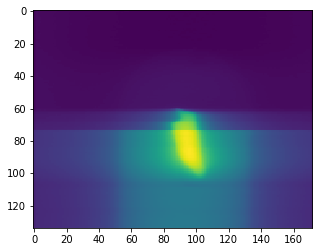

In [11]:
# Test backprojection and projection
z1 = Cop.adjoint(padded_data)
z2 = Cop.direct(z1)

plt.imshow(z1.subset(horizontal_x=68).array)
plt.show()

In [12]:
#define the operator A
L = Gradient(ig)
alpha = 0

operator_block = BlockOperator( Cop, alpha * L, shape=(2,1))

In [13]:
#define the data b
data_block = BlockDataContainer(padded_data, L.range_geometry().allocate())

In [14]:
#setup CGLS
x_init = ig.allocate(0)
cgls = CGLS(x_init=x_init, operator=operator_block, data=data_block)
cgls.max_iteration = 1000
cgls.update_objective_interval = 100

CGLS set_up called from creator


In [15]:
#run the algorithm
cgls.run(1000, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.05411e+06
      100       1000         0.162          1.48067e+05
      200       1000         0.161          7.42760e+01
      300       1000         0.161          6.79778e+01
      400       1000         0.161          6.43940e+01
      500       1000         0.160          6.16962e+01
      600       1000         0.161          5.96873e+01
      700       1000         0.161          5.80596e+01
      800       1000         0.162          5.67418e+01
      900       1000         0.162          5.56480e+01
     1000       1000         0.161          5.47311e+01


In [17]:
x_CGLS_0 = cgls.get_output()

In [23]:
alpha = 5
x_init = ig.allocate(0)
cgls = CGLS(x_init=x_init, operator=operator_block, data=data_block)
cgls.run(1000, verbose = True)

CGLS set_up called from creator
Stop cryterion has been reached.
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0          0         0.000          1.05411e+06


In [19]:
x_CGLS_5 = cgls.get_output()

In [20]:
#output = x_CGLS.as_array()
#f=open("testout.raw","wb")
#output.astype(dtype=numpy.float32).tofile(f)

In [21]:
#print(output.shape)

In [22]:
interactive_slice_display(x_CGLS_0, direction=0, auto_range='true')
interactive_slice_display(x_CGLS_5, direction=0, auto_range='true')

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

In [ ]:
# Fix color and slices for display
v1 = -0.01
v2 = 0.13
hx=80
hy=80
v=68

# Display ortho slices of reconstruction
# Display all reconstructions and decay of objective function
cols = 3
rows = 1
fig = plt.figure()

current = 1
a=fig.add_subplot(rows,cols,current)
a.set_title('horizontal_x')
imgplot = plt.imshow(x_CGLS.subset(horizontal_x=hx).as_array(),vmin=v1,vmax=v2)

current = current + 1
a=fig.add_subplot(rows,cols,current)
a.set_title('horizontal_y')
imgplot = plt.imshow(x_CGLS.subset(horizontal_y=hy).as_array(),vmin=v1,vmax=v2)

current = current + 1
a=fig.add_subplot(rows,cols,current)
a.set_title('vertical')
imgplot = plt.imshow(x_CGLS.subset(vertical=v).as_array(),vmin=v1,vmax=v2)
plt.colorbar()

plt.suptitle('CGLS reconstruction slices')
plt.show()

plt.figure()
plt.semilogy(CGLS_alg.objective)
plt.title('CGLS criterion')
plt.show()

In [ ]:
utilities.interactive_slice_display(x_CGLS, direction=0)